# Nuclear Statistical Equilibrium

Pynucastro is able to calculate the abundances at nuclear statistical equilibrium of a given reaction network by solving NSE equations using scipy.fsolve(). (see https://iopscience.iop.org/article/10.1086/510709/pdf and https://www.sciencedirect.com/science/article/abs/pii/S0092640X0800051X).

This notebook gives an illustration of this feature.

In [1]:
import pynucastro as pyna
import numpy as np
import matplotlib.pyplot as plt

We start by creating a `Library` object that reads all the ReacLib rates and link different nuclei of choice. Then initialize `RateCollection` by using the the rates created by the `Library` object.

In [2]:
library = pyna.ReacLibLibrary()

subch2_full = library.linking_nuclei(["p","he4","c12","n13","n14","o16","f18","ne20",
                                      "ne21","na22","na23","mg24","al27","si28","p31","s32",
                                     "cl35","ar36","k39","ca40","sc43","ti44","v47","cr48","mn51",
                                     "fe52","co55","ni56"])

rc = pyna.RateCollection(libraries=subch2_full)

`get_comp_NSE(rho,T,ye)` is a method of `RateCollection` that returns composition at NSE as an object `Composition` by providing density, temperature, and a presribed electron fraction. There is pre-set initial guess, however one should adjust the initial guess, accordingly if no solutions are found or taking a long time as the algorithm is searching for the correct initial guess.

This method can also print the solution that solves the nse equations by setting `tell_sol=True`, `tell_sol=False` by default.

/home/zhi/Github/pynucastro/pynucastro/networks/rate_collection.py:823: RuntimeWarning: overflow encountered in exp
  * np.exp((nuc.Z * u[0] + nuc.N * u[1] - u_c + nuc.nucbind * nuc.A) / k / T / Erg2MeV)
/home/zhi/Github/pynucastro/pynucastro/networks/rate_collection.py:822: RuntimeWarning: overflow encountered in double_scalars
  comp_NSE.X[nuc] = m_u * nuc.A_nuc * pf / rho * (2.0 * np.pi * m_u * nuc.A_nuc * k * T / h**2)**(3. / 2.) \
/usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


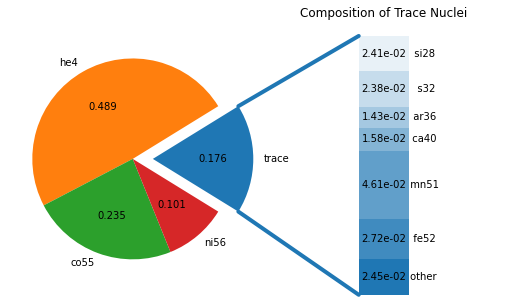

  X(p) : 0.0055147008313223365
  X(he4) : 0.48869003501935077
  X(c12) : 1.1061417700908597e-05
  X(n13) : 2.1879804842134145e-10
  X(n14) : 6.919716973675086e-10
  X(o16) : 2.5318348764353515e-05
  X(f18) : 1.3762680351825764e-11
  X(ne20) : 5.486953087870661e-07
  X(ne21) : 1.6179262695282959e-09
  X(na22) : 2.6702363077312804e-10
  X(na23) : 3.1677910819059484e-08
  X(mg24) : 7.108153472069732e-05
  X(al27) : 1.0934867015851885e-05
  X(si28) : 0.02409842221864675
  X(p31) : 0.0023542087590794044
  X(s32) : 0.023830481893803712
  X(cl35) : 0.0024858457973971023
  X(ar36) : 0.014305234932898616
  X(k39) : 0.0038879940056362706
  X(ca40) : 0.015758478261107767
  X(sc43) : 0.00014703893763741584
  X(ti44) : 0.0008535595395389682
  X(v47) : 0.004357855898206165
  X(cr48) : 0.0048203575915594125
  X(mn51) : 0.04612960699847755
  X(fe52) : 0.027173271705078793
  X(co55) : 0.2346846652733457
  X(ni56) : 0.10078926282780716



In [3]:
comp = rc.get_comp_NSE(1e7, 6e9, 0.50)
comp.plot()
print(comp)

For $\rho = 1\times 10^7 [g/cm^{3}]$ and electron fraction, $Y_e = 0.5$

In [4]:
rho = 1e7
ye = 0.5
temps = np.linspace(2.5, 12.0, 100)
X_s = []

for i, temp in enumerate(temps):
    nse_comp = rc.get_comp_NSE(rho, temp*1.0e9, ye, init_guess=[-6.0,-11.5], tell_sol=False)
    nse_X_s = [nse_comp.X[nuc] for nuc in nse_comp.X]
    X_s.append(nse_X_s)

Text(0.5, 1.0, '$Y_e = 0.5$, $\\rho = 1 \\times 10^7$')

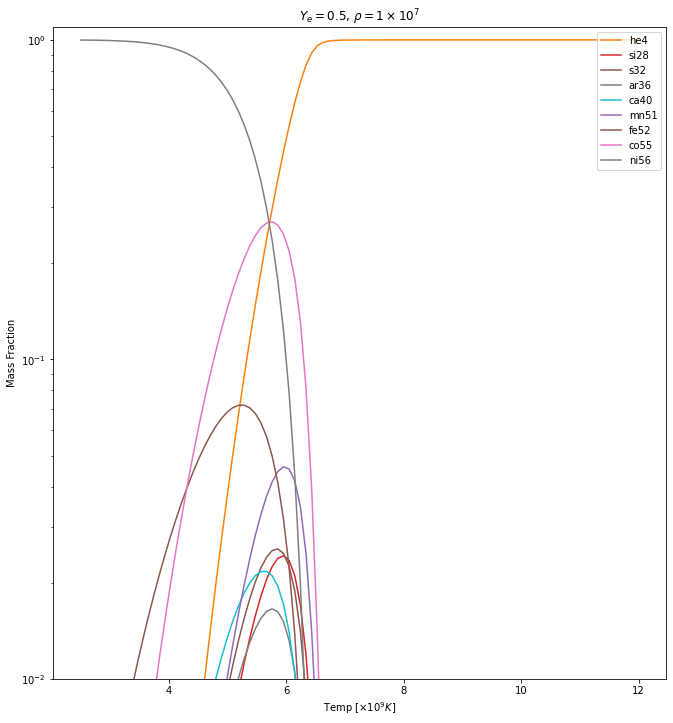

In [5]:
X_s = np.array(X_s)
nuc_names = rc.get_nuclei()

low_limit = 1e-2
fig = plt.figure(figsize=(11,12))
ax = fig.add_subplot(111)
for k in range(len(nuc_names)):
    line, = ax.plot(temps, X_s[:,k])
    if (max(X_s[:,k]) > low_limit):
        line.set_label(str(nuc_names[k]))

ax.legend(loc = "upper right")
ax.set_xlabel(r'Temp $[\times 10^9 K]$')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([low_limit,1.1])
ax.set_title(r"$Y_e = 0.5$, $\rho = 1 \times 10^7$")


For $\rho = 1\times 10^7 [g/cm^{3}]$ and a relatively high temperature of $ T = 6 \times 10^9 [K]$

In [6]:
ye_low = min(nuc.Z/nuc.A for nuc in rc.unique_nuclei)
rho = 1e7
ye_s = np.linspace(ye_low,0.65,100)
temp = 6.0e9
X_s_1 = []

for i, ye in enumerate(ye_s):
    nse_comp_1 = rc.get_comp_NSE(rho, temp, ye, init_guess=[-6.0,-11.5], tol=1.5e-10, tell_sol=False)
    nse_X_s_1 = [nse_comp_1.X[nuc] for nuc in nse_comp_1.X]
    X_s_1.append(nse_X_s_1)

/usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, '$\\rho = 1 \\times 10^7$ and $T=6 \\times 10^9$')

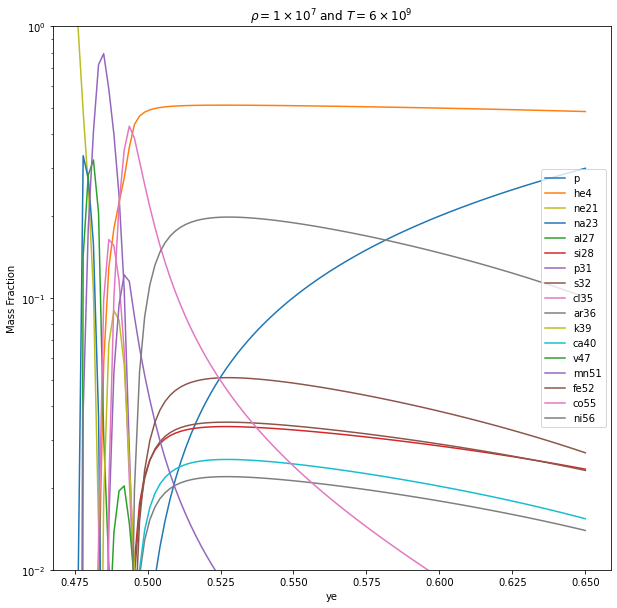

In [7]:
X_s_1 = np.array(X_s_1)
nuc_names = rc.get_nuclei()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k in range(len(nuc_names)):
    line, = ax.plot(ye_s, X_s_1[:,k])
    if (max(X_s_1[:,k]) > 0.01):
        line.set_label(str(nuc_names[k]))
ax.legend(loc = "best")
ax.set_xlabel('ye')
ax.set_ylabel('Mass Fraction')
ax.set_yscale('log')
ax.set_ylim([0.01,1])
ax.set_title(r"$\rho = 1 \times 10^7$ and $T=6 \times 10^9$")